# Figure 7 — Systemic biases

In [43]:
include("src/model.jl")
include("src/serialdep.jl")
include("src/fig_serialdep.jl");

In [65]:
plot_bias_highfreq!(ax, x, y; params...) = plot_serialdep_error!(
    ax,
    x,
    y; 
    xlabel="Target color\nrelative to common color (deg)",
    ylabel="Response bias (deg)",
    params...
);

## 1. Data (Panichello 2019, Exp 2)

In [45]:
import XLSX
using GLM

In [46]:
df_exp = DataFrame(
    XLSX.readtable(
        "../data/Panichello19/41467_2019_11298_MOESM4_ESM.xlsx", "Figure7e", "A:BI", header=false
    )...
);

In [47]:
filter(e -> typeof(e) == String, df_exp.A)

4-element Vector{Any}:
 "first third, delay = 0.5"
 "first third, delay = 4"
 "last third, delay = 0.5"
 "last third, delay = 4"

In [48]:
indices = findall(ismissing.(df_exp.B))

# first third
exp_1st_short = deg2rad.(df_exp[indices[1]+1:indices[2]-1,:] |> Matrix |> transpose)
exp_1st_long  = deg2rad.(df_exp[indices[2]+1:indices[3]-1,:] |> Matrix |> transpose)

# last third
exp_3rd_short = deg2rad.(df_exp[indices[3]+1:indices[4]-1,:] |> Matrix |> transpose)
exp_3rd_long  = deg2rad.(df_exp[indices[4]+1:end,:]          |> Matrix |> transpose);

In [49]:
exp_x = deg2rad.(collect(-30:30));

In [52]:
i_reg = abs.(rad2deg.(exp_x)) .≤ 15
x_reg = exp_x[i_reg];

In [53]:
slopes_1st_short = zeros(0)
slopes_1st_long = zeros(0)
slopes_3rd_short = zeros(0)
slopes_3rd_long = zeros(0)

for i in 1:size(exp_1st_short, 2)
    push!(slopes_1st_short, coef(lm(@formula(y ~ 1 + x), DataFrame(x=x_reg, y=exp_1st_short[i_reg,i])))[2])
    push!(slopes_1st_long,  coef(lm(@formula(y ~ 1 + x), DataFrame(x=x_reg, y=exp_1st_long[i_reg,i])))[2])
    push!(slopes_3rd_short, coef(lm(@formula(y ~ 1 + x), DataFrame(x=x_reg, y=exp_3rd_short[i_reg,i])))[2])
    push!(slopes_3rd_long,  coef(lm(@formula(y ~ 1 + x), DataFrame(x=x_reg, y=exp_3rd_long[i_reg,i])))[2])
end

In [54]:
using HypothesisTests

In [55]:
diff_short = slopes_3rd_short - slopes_1st_short
diff_long = slopes_3rd_long - slopes_1st_long

OneSampleTTest(diff_short)
OneSampleTTest(diff_long)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.190875
    95% confidence interval: (-0.3561, -0.02565)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0239

Details:
    number of observations:   120
    t-statistic:              -2.2874495713647556
    degrees of freedom:       119
    empirical standard error: 0.08344459272655727


## 2. Simulation

In [56]:
timing_short = TimingCondition("short", 1500, 500)
timing_long  = TimingCondition("long",  1500, 4000);

In [86]:
win  = π/180*4
step = win/2

add_bias_highfreq!(df) = transform!(groupby(df, :subject)) do gdf
    # add mean report and bias:
    # bias is defined as the error between a stimulus and the mean reported 
    # value for that stimulus
    mean_report = get_mean_report(gdf, :cue, :report)
    bias = cdist.(mean_report, gdf.stimulus)
    error_to_mean = cdist.(gdf.report, mean_report)
    
    return DataFrame(mean_report=mean_report, bias=bias, error_to_mean=error_to_mean)
end

smooth_bias(df) = smooth_serialdep_error(
    df; 
    distcol=:dist_from_cluster_center,
    errcol=:error,
    win=win,
    step=step,
);

In [105]:
using FileIO
df_sim = load("data/fig7.jld2", "df_sim");

In [88]:
# (45-10+1, 45+10) ./ (90/90)

In [89]:
# only use quarter of angles, since the task is symmetric
nstimuli_continuous = 90
prandom = uniform(nstimuli_continuous)

# add random phase shift
pcluster = zeros(nstimuli_continuous)
cluster_radius_deg = 10
cluster_center_deg = 45
cluster_center_rad = deg2rad(cluster_center_deg)

pcluster[36:55] .= 1
pcluster ./= sum(pcluster)

# 50%-50% chance to pick from random or from cluster 
πθ = (prandom + pcluster) / 2;

In [97]:
nsubjects = 10
nrepeats = 1

naug = 1000

# main df
df_sim = DataFrame()

for timing in [timing_short, timing_long]
    lg(timing.name)
    for subject in 1:nsubjects
        lg("$subject / $nsubjects")

        # get sim
        # 2 populations!
        sim = Simulation(
            1000, nstimuli_continuous, 2;
            seed=SEEDS[subject],
            β0=150.0,
            tunings=LinRange(0, π/2, 1000+1)[1:end-1],
            stimuli=LinRange(0, π/2, nstimuli_continuous+1)[1:end-1],
        )
        
        # make seq
        ris_uniform  = repeat([(i, timing.ri) for i in 1:sim.nstimuli], nrepeats)
        ris_highfreq = [(i, timing.ri) 
            for i in sample(sim.rng, 1:nstimuli_continuous, Weights(pcluster), nrepeats*sim.nstimuli)]
        
        order = randperm(2*nrepeats*sim.nstimuli)
        ris  = vcat(ris_uniform, ris_highfreq)[order]
        itis = [(0, timing.iti) for i in 1:2*nrepeats*sim.nstimuli]        

        seq = zip(ris, itis) |> Iterators.flatten |> collect

        # run simulation
        # no need for πθ=πθ
        _, _, rs = run!(sim, seq, warmup=10_000)
        
        # only keep cue and rs for timepoints after ri
        cues = repeat(map(s -> s[1], seq[1:2:end]), 1, sim.npopulations)
        rs   = rs[1:2:end,:,:]

        # sample report
        df = get_df_multi(sim, cues, rs; naug=div(naug, sim.npopulations))
        df.subject = fill(subject, nrow(df))
        df.timing  = fill(timing.name, nrow(df))
        
        df.is_stimulus_rand = repeat(map(i -> i ≤ length(ris_uniform), order), naug)        

        append!(df_sim, df)
    end
end

df_sim.error = cdist.(df_sim.report, df_sim.stimulus)
df_sim.dist_from_cluster_center = cdist.(df_sim.stimulus, cluster_center_rad);

[2022-02-26T13:16:31.889] short
[2022-02-26T13:16:31.889] 1 / 10
[2022-02-26T13:17:03.959] 2 / 10
[2022-02-26T13:17:41.921] 3 / 10
[2022-02-26T13:18:26.821] 4 / 10
[2022-02-26T13:18:54.211] 5 / 10
[2022-02-26T13:19:25.345] 6 / 10
[2022-02-26T13:19:55.013] 7 / 10
[2022-02-26T13:20:24.331] 8 / 10
[2022-02-26T13:20:53.039] 9 / 10
[2022-02-26T13:21:24.023] 10 / 10
[2022-02-26T13:21:53.723] long
[2022-02-26T13:21:53.724] 1 / 10
[2022-02-26T13:23:23.044] 2 / 10
[2022-02-26T13:24:48.674] 3 / 10
[2022-02-26T13:26:16.326] 4 / 10
[2022-02-26T13:27:46.130] 5 / 10
[2022-02-26T13:29:18.423] 6 / 10
[2022-02-26T13:30:55.051] 7 / 10
[2022-02-26T13:32:23.485] 8 / 10
[2022-02-26T13:33:58.472] 9 / 10
[2022-02-26T13:35:49.220] 10 / 10


In [91]:
#using FileIO
#save("data/fig7.jld2", "df_sim", df_sim)

In [106]:
df_sim_1st = @subset(df_sim, :trial .≤ :triallen ./ 3) #   .& :is_stimulus_rand
df_sim_3rd = @subset(df_sim, :trial .≥ :triallen .* 2/3) # .& :is_stimulus_rand

df_sim_1st_short = @subset(df_sim_1st, :timing .== timing_short.name)
df_sim_1st_long  = @subset(df_sim_1st, :timing .== timing_long.name)

df_sim_3rd_short = @subset(df_sim_3rd, :timing .== timing_short.name)
df_sim_3rd_long  = @subset(df_sim_3rd, :timing .== timing_long.name);

In [99]:
#add_bias_highfreq!(df_highfreq_sim_1st_short)
#add_bias_highfreq!(df_highfreq_sim_1st_long)

#add_bias_highfreq!(df_highfreq_sim_3rd_short)
#add_bias_highfreq!(df_highfreq_sim_3rd_long);

In [107]:
sim_x, sim_1st_short, e_sim_1st_short = smooth_bias(df_sim_1st_short)
sim_x, sim_1st_long , e_sim_1st_long  = smooth_bias(df_sim_1st_long)

sim_x, sim_3rd_short, e_sim_3rd_short = smooth_bias(df_sim_3rd_short)
sim_x, sim_3rd_long , e_sim_3rd_long  = smooth_bias(df_sim_3rd_long);

In [101]:
#i_reg = abs.(rad2deg.(sim_x)) .≤ 15
#x_reg = sim_x[i_reg];

In [102]:
#histogram(rad2deg.(df_sim.dist_from_cluster_center))

## 3. Final figure

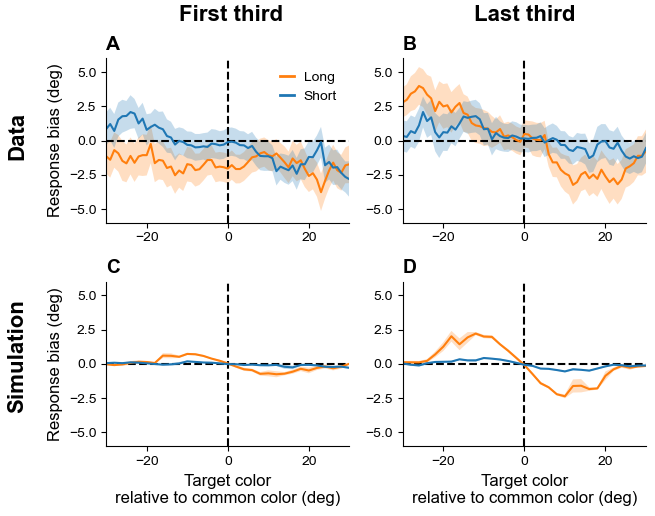

In [113]:
fig = figure("fig7_systemicbiases", figsize=(7, 5))

# A: RI
ax = subplot(221)
plt.title("A")

ax.axhline(y = 0, color = "k", linestyle = "--")
ax.axvline(x = 0, color = "k", linestyle = "--")

plot_bias_highfreq!(ax, exp_x, exp_1st_long;  color=get_palette(2), label="Long")
plot_bias_highfreq!(ax, exp_x, exp_1st_short; color=get_palette(1), label="Short")

ax.set_xlim(-30, 30)
ax.set_ylim(-6, 6)

legend() |> legend_shorten_lines!
ax.set_xlabel("")

# B: ITI
ax = subplot(222)
plt.title("B")

ax.axhline(y = 0, color = "k", linestyle = "--")
ax.axvline(x = 0, color = "k", linestyle = "--")

plot_bias_highfreq!(ax, exp_x, exp_3rd_long;  color=get_palette(2), label="Long")
plot_bias_highfreq!(ax, exp_x, exp_3rd_short; color=get_palette(1), label="Short")

ax.set_xlim(-30, 30)
ax.set_ylim(-6, 6)

ax.set_xlabel("")
ax.set_ylabel("")

# C: RI
ax = subplot(223)
plt.title("C")

ax.axhline(y = 0, color = "k", linestyle = "--")
ax.axvline(x = 0, color = "k", linestyle = "--")

plot_bias_highfreq!(ax, sim_x, sim_1st_long;  color=get_palette(2), label="Long")
plot_bias_highfreq!(ax, sim_x, sim_1st_short; color=get_palette(1), label="Short")

ax.set_xlim(-30, 30)
ax.set_ylim(-6, 6)


# D: ITI
ax = subplot(224)
plt.title("D")

ax.axhline(y = 0, color = "k", linestyle = "--")
ax.axvline(x = 0, color = "k", linestyle = "--")

plot_bias_highfreq!(ax, sim_x, sim_3rd_long;  color=get_palette(2), label="Long")
plot_bias_highfreq!(ax, sim_x, sim_3rd_short; color=get_palette(1), label="Short")

ax.set_xlim(-30, 30)
ax.set_ylim(-6, 6)

ax.set_ylabel("")


# Update the figure
fig.tight_layout(w_pad=2, rect=(0.06, 0, 0.94, 1)) # (left, bottom, right, top)

# add Data and Simulation annotations
annotate_data_simulation_side!(y1=0.76, y2=0.32)
annotate_data_simulation_top!("First third", "Last third"; x1=0.33, x2=0.75);

In [114]:
fig.savefig("figs/fig7_systemicbiases.pdf", bbox_inches="tight");